In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from os import walk
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from torchvision.utils import make_grid
from torch.utils.data  import Dataset,DataLoader
from torchvision import transforms,datasets, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import re


import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib


batch_size = 32
num_epoch = 25

In [ ]:
class Mosquito_dataset(Dataset):
    
    def __init__(self,root_dir,transform=None):
        super(Mosquito_dataset,self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {'aedss':0, 'bandarabbas':1, 'chabaharr':1, 'kazeronn':1, 'culexx':2}
        # self.classes = ['aedes', 'Irani', 'kulex']
        self.filenames = [] 
        self.labels = []
        for  dirname in os.listdir(root_dir):
            class_add = os.path.join(root_dir, dirname)
            for file in os.listdir(class_add):
                self.filenames.append(os.path.join(class_add, file))
                self.labels.append(self.classes[dirname]) 

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self,idx): 
        img = Image.open(self.filenames[idx])#.convert('RGB')
#         img = np.expand_dims(img,axis=2)
#         img = np.repeat(img[..., np.newaxis], 3, -1)
        
        if self.transform:
            img = self.transform(img)
            

        return img,self.labels[idx]

In [ ]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/MyDrive/finalmosquito-20210418T160607Z-001/finalmosquito/'
image_datasets = {x: Mosquito_dataset(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train','Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True if x== 'Train' else False, num_workers=0)
              for x in ['Train','Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train','Test']}

class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
len(image_datasets['Train'])

552

In [ ]:
def imshow(dl,nrows , ncols):
    """Imshow for Tensor."""
    
    fig , axs = plt.subplots(nrows=nrows,ncols=ncols,figsize= (15,10))
    axs = axs.ravel()

    i=0
    
    class_names = ['aedss', 'bandarabbas', 'chabaharr', 'kazeronn', 'culexx']
    for inputs, classes in dl:
        
        for image,label in zip(inputs,classes):
            
            inp = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            axs[i].imshow(inp)
            axs[i].set_title(class_names[label])
            axs[i].axis('off')
            
            i+=1
            
            if i==nrows*ncols :
                return


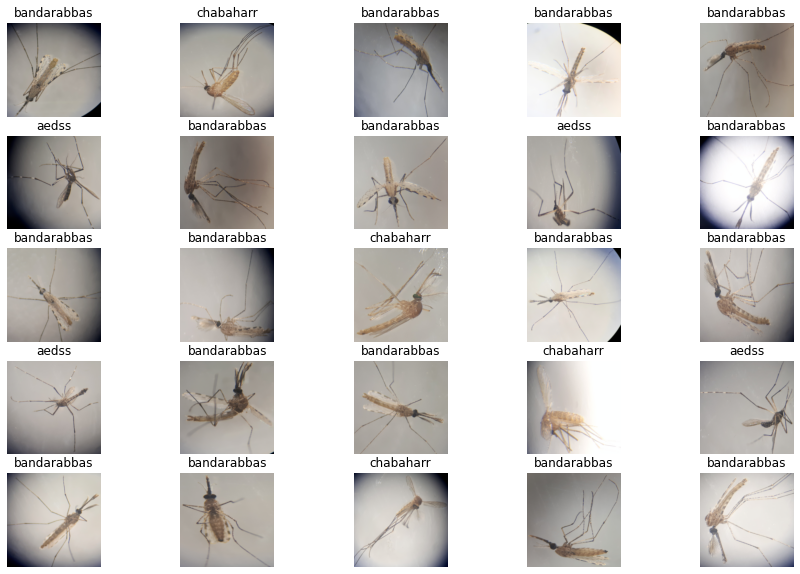

In [ ]:
imshow(dataloaders['Train'], nrows = 5 , ncols = 5)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # print cuda or cpu mode
    if torch.cuda.is_available():
        print('--------- Training in Cuda Mode ----------')
    else:
        print('--------- Training in Cpu Mode ----------')
    
    
    #loading checkpoin
    if os.path.exists('checkpoint.tar'):
        checkpoint = torch.load('checkpoint.tar')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        last_epoch = checkpoint['epoch']
        last_time_elapsed = checkpoint['time']
        best_acc = checkpoint['best_acc']
        losses= checkpoint['losses']
    else:
        last_epoch = 0
        last_time_elapsed = 0
        best_acc = 0.0
    
        losses= {'Train':[], 'Test':[]}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(last_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # save checkpoint
        torch.save({'epoch': epoch+1,
                    'model_state_dict': best_model_wts,
                    'best_acc' : best_acc,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'time': time.time() - since,
                    'losses' : losses
                   },'checkpoint.tar')
        print()

    
    time_elapsed = time.time() - since + last_time_elapsed
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    plt.plot(losses['Train'], label='Training loss')
    plt.plot(losses['Test'], label='Validation loss')
    idx = np.argmin(losses['Test'])
    plt.plot([idx,idx], [0,losses['Test'][idx]],'--', color= 'coral' , label = 'Best' )
    plt.plot([0,idx], [losses['Test'][idx],losses['Test'][idx]],'--', color= 'coral' )
    plt.plot(idx, losses['Test'][idx] , 'o' ,color = 'coral', markersize = 8, markerfacecolor = "None" )
    plt.legend()
    plt.ylabel('Loss', fontsize= 12)
    plt.xlabel('Epoch',fontsize= 12)
    plt.tight_layout()
    plt.title(f'{model_name} Train-Test loss ',fontsize= 12)
    plt.savefig(f'loss_{model_name}.png',bbox_inches='tight')
    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test_model(model,dataloader):
    # print cuda or cpu mode
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print('--------- Cuda Mode ----------')
    else:
        print('--------- Cpu Mode ----------')
    print('Predicting...')
    predictions = np.array([])
    targets = np.array([])
    model.eval()   # Set model to evaluate mode
    since = time.time()
    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        predictions =  np.append(predictions,preds.cpu().numpy())
        targets =  np.append(targets,labels.cpu().numpy())

    print()

    
    time_elapsed = time.time() - since
    print('Testing completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return targets, predictions

In [ ]:
def show_misclass(model, dataloader,nrows,ncols):
    model.eval()
    images_so_far = 0
        
    fig , axs = plt.subplots(nrows=nrows,ncols=ncols,figsize= (15,10))
    plt.subplots_adjust(hspace = 0.3)
    axs = axs.ravel()
    
    for inputs, labels in dataloader:
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in torch.nonzero(preds!= labels):
                image = inputs[i.item()].cpu()
                inp = image.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
            
                axs[images_so_far].imshow(inp)
                axs[images_so_far].set_title(f"Pred:{class_names[preds[i]]} \n (True:{class_names[labels[i]]})" )
                axs[images_so_far].axis('off')
                images_so_far+=1

            if images_so_far==nrows*ncols :
                return

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize= (7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",verticalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

--------- Training in Cpu Mode ----------
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.7725 Acc: 0.7591
Test Loss: 0.4287 Acc: 0.8200

Epoch 1/19
----------
Train Loss: 0.1842 Acc: 0.9384
Test Loss: 0.0546 Acc: 1.0000

Epoch 2/19
----------
Train Loss: 0.0504 Acc: 0.9909
Test Loss: 0.0290 Acc: 1.0000

Epoch 3/19
----------
Train Loss: 0.0561 Acc: 0.9837
Test Loss: 0.0333 Acc: 1.0000

Epoch 4/19
----------
Train Loss: 0.0579 Acc: 0.9855
Test Loss: 0.0226 Acc: 1.0000

Epoch 5/19
----------
Train Loss: 0.0229 Acc: 0.9982
Test Loss: 0.0144 Acc: 1.0000

Epoch 6/19
----------
Train Loss: 0.0222 Acc: 0.9982
Test Loss: 0.0128 Acc: 1.0000

Epoch 7/19
----------
Train Loss: 0.0206 Acc: 0.9964
Test Loss: 0.0165 Acc: 1.0000

Epoch 8/19
----------
Train Loss: 0.0210 Acc: 0.9964
Test Loss: 0.0127 Acc: 1.0000

Epoch 9/19
----------
Train Loss: 0.0186 Acc: 1.0000
Test Loss: 0.0123 Acc: 1.0000

Epoch 10/19
----------
Train Loss: 0.0186 Acc: 1.0000
Test Loss: 0.0126 Acc: 1.0000

Epoch 11/19
----------
Train Loss: 0.0205 Acc: 0.9946
Test Loss: 0.0137 Acc: 1.0000

Epoch 12/19


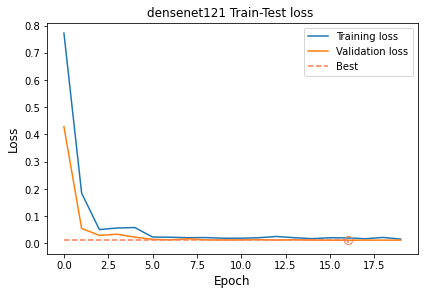

In [ ]:
mymodels = {'densenet121' : models.densenet121 , 
            'resnet18': models.resnet18 ,
            'resnet50': models.resnet50,
            'vgg16bn' : models.vgg16_bn,
            'alexnet' : models.alexnet
           }

model_name = 'vgg16bn'

if (model_name == 'resnet18'):
    # -------------- Resnet18 ---------------------
    model_ft = models.resnet18(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 3)
    
elif (model_name == 'resnet50'):
    # -------------- Resnet50  -------------------
    model_ft = models.resnet50(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 3)

elif (model_name == 'densenet121'):
    # --------------Dense Net  -------------------
    model_ft = models.densenet121(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, 3)

elif (model_name == 'vgg16bn'):
    # -------------- VGG16_bn  ------------------ 
    model_ft = models.vgg16_bn(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(in_features= in_features ,out_features=3 )

elif (model_name == 'alexnet'):
    # ----------------Alexnet  -------------------
    model_ft = models.alexnet(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(in_features= in_features ,out_features=3 )

    
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

if os.path.exists(f'best_model_{model_name}.pth'): 
    model_ft.load_state_dict(torch.load(f'best_model_{model_name}.pth'))
    
else:
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
    torch.save(model_ft.state_dict(), f'best_model_{model_name}.pth')

In [ ]:
# test model
targets , preds = test_model(model_ft,dataloaders['Test'])


--------- Cpu Mode ----------
Predicting...

Testing completed in 0m 11s


In [ ]:
print("Classification Report")
print(classification_report(targets , preds))


Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        30
         2.0       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



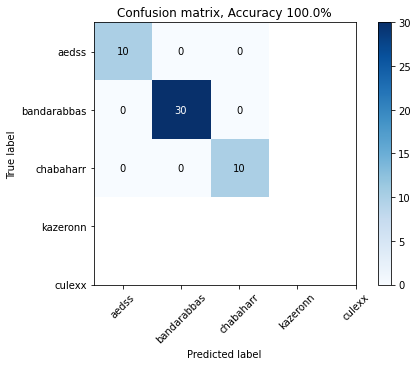

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(targets , preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = image_datasets['Test'].classes
acc = accuracy_score(targets , preds)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')
plt.savefig(f'conf_{model_name}.png')

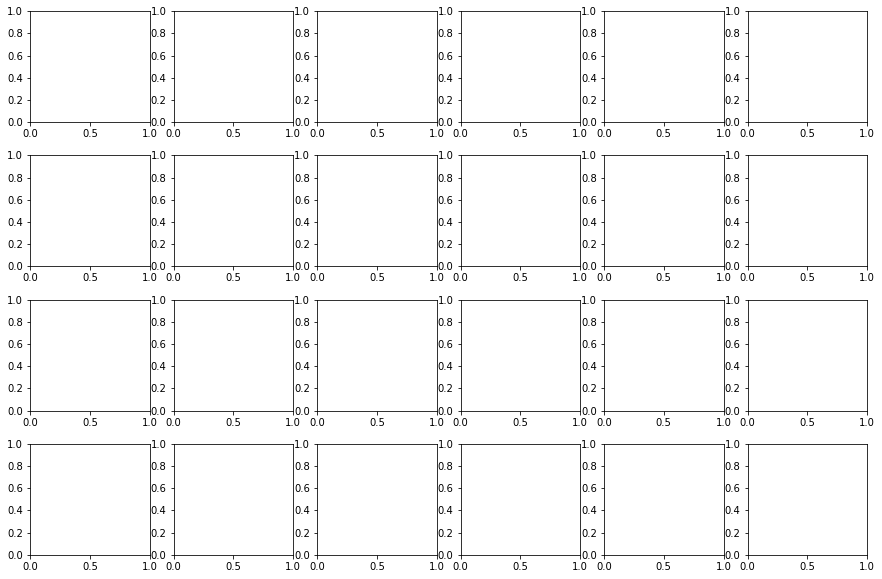

In [ ]:
show_misclass(model_ft, dataloaders['Test'],4,6)

In [ ]:
targets , preds = test_model(model_ft,dataloaders['Train'])

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(targets , preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = image_datasets['Test'].classes
acc = accuracy_score(targets , preds)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')
plt.savefig(f'conf_{model_name}.png')

In [ ]:
model = models.densenet121(pretrained=False)
for param in model.parameters():
        param.requires_grad = False
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3)


checkpoint = torch.load('checkpoint.tar')

In [ ]:
model = models.resnet50(pretrained=True)
target_layer = model.layer4[-1]

In [ ]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

ModuleNotFoundError: ignored

In [ ]:
for name, param in model.named_parameters():
  print(name)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

In [ ]:
model = models.densenet121()